# If using scanpy data

In [1]:
#this part is not important, only a simple example of scanpy processing to get a list of genes
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context

my_data_path = 'path/to/data/outs/filtered_feature_bc_matrix'

def pp(path):
    adata = sc.read_10x_mtx(path)
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    
    
    #find markers
    results = adata.uns['rank_genes_groups']
    out = np.array([[0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                         results['scores'][group],
                                         results['pvals_adj'][group],
                                         results['logfoldchanges'][group],
                                         np.array([group] * len(results['names'][group])).astype('object'))).T))
    markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])
    adata.uns['markers'] = markers #save marker df to uns

    
    return adata



In [9]:
adata = pp(my_data_path)

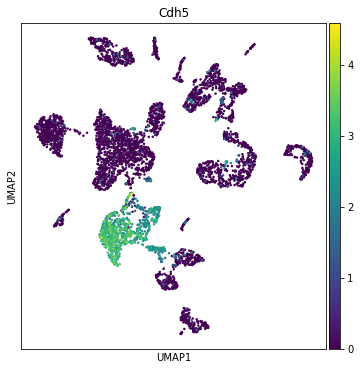

In [4]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color='Cdh5')

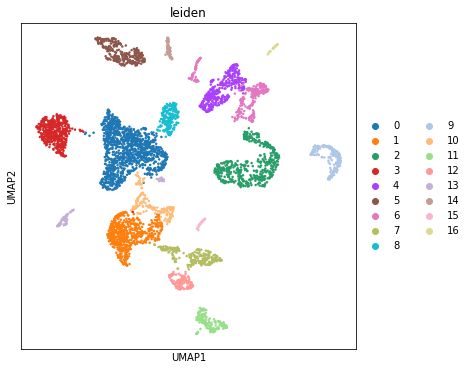

In [3]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'leiden')

In [5]:
ec_markers = adata.uns['markers']
ec_markers = ec_markers[(ec_markers.cluster == '1') & (ec_markers.pval_adj < 0.05) & (ec_markers.lfc > 1.5)]
ec_markers

,Gene,scores,pval_adj,lfc,cluster
19566,Fabp4,38.404152,0.0,7.357558,1
19567,Cdh5,38.241219,0.0,6.285158,1
19568,Cav1,38.071117,0.0,4.605687,1
19569,Flt1,37.972519,0.0,6.320522,1
19570,Egfl7,37.810642,0.0,5.874594,1
...,...,...,...,...,...
20925,P2ry2,2.511215,0.045055,2.368968,1
20928,Vegfc,2.500475,0.046302,1.625132,1
20929,Gbp3,2.496509,0.046769,1.562324,1
20931,Hoxd8,2.492298,0.047242,1.570327,1


# START GO example

In [6]:
# !pip install goatools

In [ ]:
#first need to make background gene set

#https://www.ncbi.nlm.nih.gov/gene
# Mouse is 10090   
# "10090"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]
# Human is 9606
# "9606"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]

#send to file

In [17]:
# !mv path/to/Downloads/gene_result.txt .
# !python path/to/miniconda3/envs/sc/bin/ncbi_gene_results_to_python.py -o genes_ncbi_mus_musculus_proteincoding.py gene_result.txt
# #move created file to default import location so you dont have to make every time

# !python /home/tealeave/mambaforge/envs/bio_test/bin/ncbi_gene_results_to_python.py -o genes_ncbi_homo_sapiens_proteincoding.py gene_result.txt
# !mv genes_ncbi_homo_sapiens_proteincoding.py /home/tealeave/mambaforge/envs/bio_test/lib/python3.9/site-packages/


      26,385 lines READ:  gene_result.txt
      26,371 geneids WROTE: genes_ncbi_mus_musculus_proteincoding.py


In [2]:
# from genes_ncbi_mus_musculus_proteincoding import GENEID2NT as GeneID2nt_mus
# gotta use bio_test env
from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hom

In [3]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [4]:
#run one time to initialize, download some NCBI data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

$ get http://purl.obolibrary.org/obo/go/go-basic.obo
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

$ get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
$ gunzip gene2go.gz
go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms


In [10]:
obodag

{'GO:0000001': GOTerm('GO:0000001'):
   id:GO:0000001
   item_id:GO:0000001
   name:mitochondrion inheritance
   namespace:biological_process
   _parents: 2 items
     GO:0048311
     GO:0048308
   parents: 2 items
     GO:0048308	level-05	depth-05	organelle inheritance [biological_process]
     GO:0048311	level-04	depth-06	mitochondrion distribution [biological_process]
   children: 0 items
   level:5
   depth:7
   is_obsolete:False
   alt_ids: 0 items,
 'GO:0000002': GOTerm('GO:0000002'):
   id:GO:0000002
   item_id:GO:0000002
   name:mitochondrial genome maintenance
   namespace:biological_process
   _parents: 1 items
     GO:0007005
   parents: 1 items
     GO:0007005	level-05	depth-05	mitochondrion organization [biological_process]
   children: 0 items
   level:6
   depth:6
   is_obsolete:False
   alt_ids: 0 items,
 'GO:0000003': GOTerm('GO:0000003'):
   id:GO:0000003
   item_id:GO:0000003
   name:reproduction
   namespace:biological_process
   _parents: 1 items
     GO:0008150
  

In [14]:
# 7157 is PT53's gene number
GeneID2nt_hom[7157].Symbol, GeneID2nt_hom[7157].GeneID

('TP53', 7157)

In [5]:
# Create fwd and rev gene id mapper
# run one time to initialize
mapper = {}

# for key in GeneID2nt_mus:
#     mapper[GeneID2nt_mus[key].Symbol] = GeneID2nt_mus[key].GeneID

for key in GeneID2nt_hom:
    mapper[GeneID2nt_hom[key].Symbol] = GeneID2nt_hom[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}
mapper

{'A1BG': 1,
 'A2M': 2,
 'NAT1': 9,
 'NAT2': 10,
 'SERPINA3': 12,
 'AADAC': 13,
 'AAMP': 14,
 'AANAT': 15,
 'AARS1': 16,
 'ABAT': 18,
 'ABCA1': 19,
 'ABCA2': 20,
 'ABCA3': 21,
 'ABCB7': 22,
 'ABCF1': 23,
 'ABCA4': 24,
 'ABL1': 25,
 'AOC1': 26,
 'ABL2': 27,
 'ABO': 28,
 'ABR': 29,
 'ACAA1': 30,
 'ACACA': 31,
 'ACACB': 32,
 'ACADL': 33,
 'ACADM': 34,
 'ACADS': 35,
 'ACADSB': 36,
 'ACADVL': 37,
 'ACAT1': 38,
 'ACAT2': 39,
 'ASIC2': 40,
 'ASIC1': 41,
 'ACHE': 43,
 'ACLY': 47,
 'ACO1': 48,
 'ACR': 49,
 'ACO2': 50,
 'ACOX1': 51,
 'ACP1': 52,
 'ACP2': 53,
 'ACP5': 54,
 'ACP3': 55,
 'ACRV1': 56,
 'ACTA1': 58,
 'ACTA2': 59,
 'ACTB': 60,
 'ACTC1': 70,
 'ACTG1': 71,
 'ACTG2': 72,
 'ACTN4': 81,
 'ACTL6A': 86,
 'ACTN1': 87,
 'ACTN2': 88,
 'ACTN3': 89,
 'ACVR1': 90,
 'ACVR1B': 91,
 'ACVR2A': 92,
 'ACVR2B': 93,
 'ACVRL1': 94,
 'ACY1': 95,
 'ACYP1': 97,
 'ACYP2': 98,
 'ADA': 100,
 'ADAM8': 101,
 'ADAM10': 102,
 'ADAR': 103,
 'ADARB1': 104,
 'ADARB2': 105,
 'ADCY1': 107,
 'ADCY2': 108,
 'ADCY3': 109,
 '

In [6]:
#run one time to initialize

# Read NCBI's gene2go. Store annotations in a list of namedtuples
# objanno = Gene2GoReader(fin_gene2go, taxids=[10090])
# fin_gene2go is a dict of dicts:
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:03.370797 343,513 annotations, 20,757 genes, 18,851 GOs, 1 taxids READ: gene2go 


In [18]:
#run one time to initialize
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hom.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 82% 16,989 of 20,652 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,125 of 20,652 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,580 of 20,652 population items found in association


In [19]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

# There will be repeated go term in this list
GO_items.count('GO:0001525')

245

In [9]:
#pass list of gene symbols
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}') 
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO


In [31]:
# get the gene list
import pandas as pd
gene_df = pd.read_csv('DE_results.csv', header=0)
gene_df = gene_df[ (gene_df.padj < 0.05) & (gene_df.log2FoldChange > 1)]
# get the gene list
gene_df.sort_values(by='padj', ascending=True, inplace=True)
gene_list = gene_df.symbol.tolist()

In [32]:
df = go_it(gene_list)

input genes: 172
mapped genes: 162

Runing BP Ontology Analysis: current study set of 162 IDs.
 93%    151 of    162 study items found in association
100%    162 of    162 study items found in population(20652)
Calculating 12,298 uncorrected p-values using fisher_scipy_stats
  12,298 terms are associated with 16,989 of 20,652 population items
   1,100 terms are associated with    151 of    162 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 162 IDs.
 99%    160 of    162 study items found in association
100%    162 of    162 study items found in population(20652)
Calculating 1,793 uncorrected p-values using fisher_scipy_stats
   1,793 terms are associated with 18,125 of 20,652 population items
     244 terms are associated 

In [33]:
df

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:2000352,negative regulation of endothelial cell apopto...,biological_process,4.022404e-06,4.946753e-02,5,162,36,"[SCG2, ICAM1, ANGPTL4, GAS6, SERPINE1]"
1,GO:0005615,extracellular space,cellular_component,1.077210e-11,1.931437e-08,40,162,1867,"[ADM, MMP24, NPPB, THBS1, CTSF, ABCA3, SERPINE..."
2,GO:0070062,extracellular exosome,cellular_component,7.185012e-10,6.441363e-07,44,162,2211,"[IGSF8, CRYAB, DPP4, MMP24, H2AC6, THBS1, CTSF..."
3,GO:0005576,extracellular region,cellular_component,5.645033e-09,3.373848e-06,39,162,1969,"[ADM, DPP4, NPPB, FNDC1, AMPD3, THBS1, HEG1, S..."
4,GO:0062023,collagen-containing extracellular matrix,cellular_component,8.767632e-09,3.930091e-06,17,162,382,"[VTN, LAMA3, SERPING1, CLU, ANGPTL1, GDF15, TH..."
5,GO:0005886,plasma membrane,cellular_component,6.645441e-06,2.383055e-03,64,162,5169,"[SORT1, IGSF8, SHANK1, RND3, ABCC3, ABCB1, DPP..."
6,GO:0008043,intracellular ferritin complex,cellular_component,6.115581e-05,1.673068e-02,2,162,2,"[FTL, FTH1]"
7,GO:0005764,lysosome,cellular_component,6.919481e-05,1.673068e-02,10,162,277,"[SORT1, EPDR1, CRYAB, DRAM1, CPQ, CTSF, FUCA1,..."
8,GO:0044754,autolysosome,cellular_component,7.464889e-05,1.673068e-02,3,162,11,"[FTL, SQSTM1, FTH1]"
9,GO:0043204,perikaryon,cellular_component,1.772183e-04,3.265625e-02,7,162,149,"[MYO1D, CRYAB, AZIN2, AMIGO1, ITGA1, SERPINI1,..."


In [40]:
df['percent'] = df.n_genes/df.n_go

/tmp/ipykernel_16651/3275787480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent'] = df.n_genes/df.n_go


In [41]:
df = df[0:10]

In [42]:
df

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per,percent
0,GO:2000352,negative regulation of endothelial cell apopto...,biological_process,4.022404e-06,4.946753e-02,5,162,36,"[SCG2, ICAM1, ANGPTL4, GAS6, SERPINE1]",0.138889,0.138889
1,GO:0005615,extracellular space,cellular_component,1.077210e-11,1.931437e-08,40,162,1867,"[ADM, MMP24, NPPB, THBS1, CTSF, ABCA3, SERPINE...",0.021425,0.021425
2,GO:0070062,extracellular exosome,cellular_component,7.185012e-10,6.441363e-07,44,162,2211,"[IGSF8, CRYAB, DPP4, MMP24, H2AC6, THBS1, CTSF...",0.019900,0.019900
3,GO:0005576,extracellular region,cellular_component,5.645033e-09,3.373848e-06,39,162,1969,"[ADM, DPP4, NPPB, FNDC1, AMPD3, THBS1, HEG1, S...",0.019807,0.019807
4,GO:0062023,collagen-containing extracellular matrix,cellular_component,8.767632e-09,3.930091e-06,17,162,382,"[VTN, LAMA3, SERPING1, CLU, ANGPTL1, GDF15, TH...",0.044503,0.044503
5,GO:0005886,plasma membrane,cellular_component,6.645441e-06,2.383055e-03,64,162,5169,"[SORT1, IGSF8, SHANK1, RND3, ABCC3, ABCB1, DPP...",0.012382,0.012382
6,GO:0008043,intracellular ferritin complex,cellular_component,6.115581e-05,1.673068e-02,2,162,2,"[FTL, FTH1]",1.000000,1.000000
7,GO:0005764,lysosome,cellular_component,6.919481e-05,1.673068e-02,10,162,277,"[SORT1, EPDR1, CRYAB, DRAM1, CPQ, CTSF, FUCA1,...",0.036101,0.036101
8,GO:0044754,autolysosome,cellular_component,7.464889e-05,1.673068e-02,3,162,11,"[FTL, SQSTM1, FTH1]",0.272727,0.272727
9,GO:0043204,perikaryon,cellular_component,1.772183e-04,3.265625e-02,7,162,149,"[MYO1D, CRYAB, AZIN2, AMIGO1, ITGA1, SERPINI1,...",0.046980,0.046980


In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap

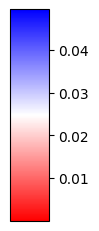

In [44]:
fig, ax = plt.subplots(figsize = (0.5, 2.75))

cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin = df.p_corr.min(), vmax = df.p_corr.max())

mapper = cm.ScalarMappable(norm = norm, cmap = cm.bwr_r)

cbl = mpl.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, orientation = 'vertical')

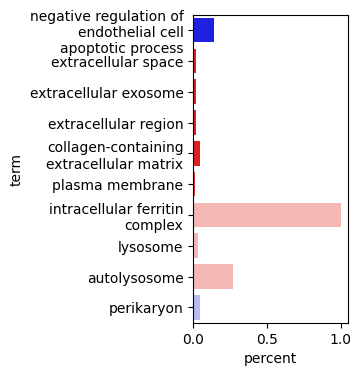

In [46]:
plt.figure(figsize = (2,4))



ax = sns.barplot(data = df, x = 'percent', y = 'term', palette = mapper.to_rgba(df.p_corr.values))

ax.set_yticklabels([textwrap.fill(e, 22) for e in df['term']])

plt.show()